In [1]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import pyplot as plt
from scipy.stats import pearsonr

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
#query the station table from sqlite
station_results = session.query(Station.id, Station.station, Station.name,Station.latitude,Station.longitude,Station.elevation).\
    order_by(Station.id.asc()).all()

In [11]:
#store the data from station sql table to pandas df
station_df = pd.DataFrame(station_results, columns=['id', 'station', 'name','latitude','longitude','elevation'])
station_df.head()

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


In [12]:
#query the measurement table from sqlite
measurement_results = session.query(Measurement.id, Measurement.station, Measurement.date,Measurement.prcp,Measurement.tobs).\
    order_by(Measurement.id.asc()).all()

In [13]:
#store the data from measurement sql table to pandas df
measurement_df = pd.DataFrame(measurement_results, columns=['id', 'station', 'date','prcp','tobs'])
measurement_df.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

#step 1, calculate start date and end date in order to query 12 months of precipitation data:

#query for the latest/max date from measurement table
max_date_query = session.query(Measurement.date, func.max(Measurement.date).label("latest_date"))

#from query result, store the lates/max date as end date
max_date_result = max_date_query.one()
max_date_str = max_date_result.latest_date

#convert max date into datetime data type
max_date_dt = datetime.strptime(max_date_str, '%Y-%m-%d')

# Calculate the date 1 year ago from max date of measurement table
year_ago_date_dt = max_date_dt - dt.timedelta(days=365)

# convert the date of 1 year ago into string
year_ago_date_str = year_ago_date_dt.strftime('%Y-%m-%d')

#check for start date and end date of 12 months range
print('12 months range of measurement table:')
print('from ' + year_ago_date_str + ' to ' + max_date_str)


12 months range of measurement table:
from 2016-08-23 to 2017-08-23


In [15]:
# Perform a query to retrieve the data and precipitation scores:

# groupby date and calculate average precipitation socres due to multiple precipitation found from measurement table
#prcp_results = session.query(Measurement.date,func.avg(Measurement.prcp)).\
#    filter(Measurement.date >= year_ago_date).group_by(Measurement.date).order_by(Measurement.date.asc()).all()

prcp_results = session.query(Measurement.date,Measurement.prcp).\
    filter(Measurement.date >= year_ago_date_str,Measurement.date<= max_date_str).order_by(Measurement.date.asc()).all()
    
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_results, columns=['date', 'prcp'])

#prcp_df = prcp_df.set_index('date',inplace=True)

##count_chicago_crime_df = count_chicago_crime_df.reset_index()
prcp_df.head()

# Sort the dataframe by date
# n/a --- sorting have done through session query


,date,prcp
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,NaN
4,2016-08-23,0.02


In [16]:
#group by date in order and calculate mean of precipitation scores for plotting the data 

#given the date is not unique from measurement table and precipitation scores are recorded per date and per multiple stations

#calculate mean of precipitation
prcp_groupby_dt = prcp_df.groupby('date')['prcp'].mean()

#create a new dataframe for group by date and average precipitation
prcp_groupby_dt_df = pd.DataFrame({'prcp':prcp_groupby_dt})

#reset index
prcp_groupby_dt_df = prcp_groupby_dt_df.reset_index()

#check for result
prcp_groupby_dt_df.head()
                                

,date,prcp
0,2016-08-23,0.451667
1,2016-08-24,1.555000
2,2016-08-25,0.077143
3,2016-08-26,0.016667
4,2016-08-27,0.064000


<IPython.core.display.Javascript object>


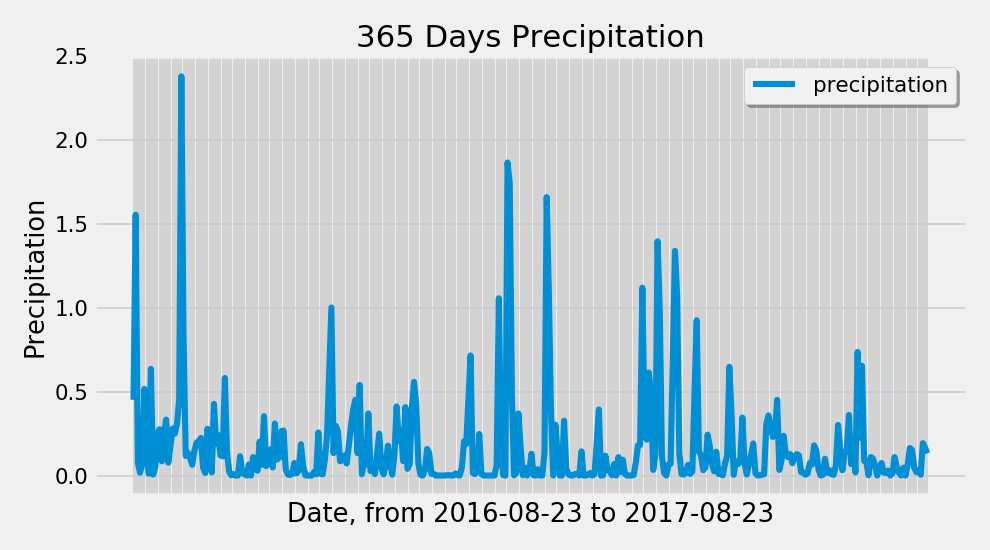

In [81]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(1, figsize=(9,5))
plt.plot(prcp_groupby_dt_df['date'], prcp_groupby_dt_df['prcp'],label='precipitation')

plt.xlabel("Date, from " + year_ago_date_str + ' to ' + max_date_str)
plt.ylabel("Precipitation")
plt.title("365 Days Precipitation")

#set legend
legend = plt.legend(loc='upper right', shadow=True)

# Rotate the xticks for the dates
#plt.xticks(np.arange(min(prcp_df['date']), max(prcp_df['date']), 1.0))
#plt.locator_params(numticks=12)

#remove xticks due to large number of x (365 days!)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

#show the linear plot
plt.grid(True)
plt.tight_layout()
plt.show()


In [42]:
# Use Pandas to calcualte the summary statistics for the precipitation data

#summary statistics for all data from measurement
#prcp_df.describe()

#summary statistics for the precipitation data of 12 months
prcp_groupby_dt_df.describe()

,prcp
count,366.000000
mean,0.170757
std,0.295683
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


In [19]:
# How many stations are available in this dataset?
count_station = measurement_df['station'].unique()
print("total number of station: " + str(len(count_station)))

total number of station: 9


In [29]:
# What are the most active stations?
# List the stations and the counts in descending order.
active_stations_count = measurement_df.groupby('station')['station'].count()
active_stations_count_df = pd.DataFrame({'#_of_station':active_stations_count})
active_stations_count_df = active_stations_count_df.sort_values(by='#_of_station',ascending=False)
active_stations_count_df = active_stations_count_df.reset_index()
active_stations_count_df

,station,#_of_station
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [44]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

#get the most active station id
most_active_station = active_stations_count_df.nlargest(1,'#_of_station')
most_active_station = most_active_station['station'].iloc[0]
most_active_station

#filter the measurement df by the most active station id
most_active_station_df = measurement_df[measurement_df['station'] == most_active_station]

#use pandas describe for min, max and average temperature
most_active_station_df['tobs'].describe().loc[['min','max','mean']]

min     54.000000
max     85.000000
mean    71.663781
Name: tobs, dtype: float64

In [61]:
# Choose the station with the highest number of temperature observations.

#get station with the highest temperature from measurement df
high_temp_station = measurement_df.nlargest(1,'tobs')
high_temp_station = high_temp_station['station'].iloc[0]
print('station with the highest temperature: ' + high_temp_station)

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
high_temp_station_results = session.query(Measurement.tobs,\
                                          func.count(Measurement.tobs).label('frequency')).\
                                            filter(Measurement.date >= year_ago_date_str,\
                                                   Measurement.station == high_temp_station).\
                                            group_by(Measurement.tobs).order_by(Measurement.date.asc()).all()

high_temp_station_12m_df = pd.DataFrame(high_temp_station_results, columns=['tobs','frequency'])
high_temp_station_12m_df.head()

station with the highest temperature: USC00519397


,tobs,frequency
0,60.0,1
1,67.0,7
2,62.0,4
3,61.0,2
4,64.0,5


<IPython.core.display.Javascript object>


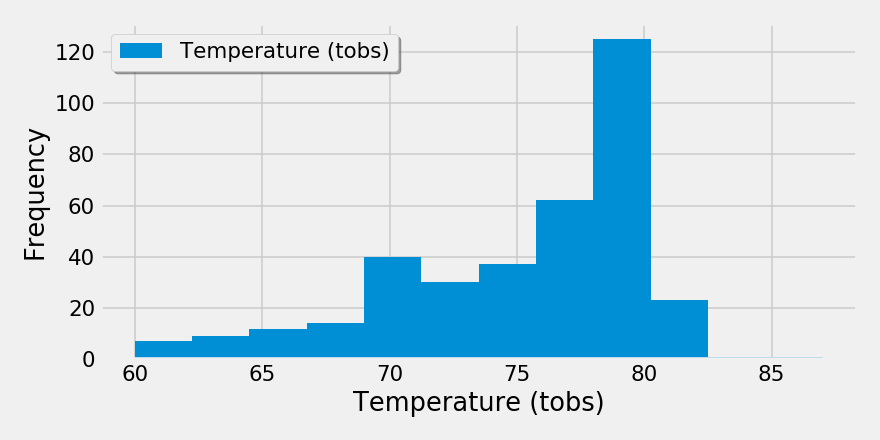

In [115]:
#plot the results as a histogram
plt.figure(2, figsize=(8,4))

plt.hist(high_temp_station_12m_df.tobs,weights=high_temp_station_12m_df.frequency,bins=12,label='Temperature (tobs)')

plt.xlabel('Temperature (tobs)')
plt.ylabel("Frequency")

#set legend
legend = plt.legend(loc='upper left', shadow=True)

#show the hist plot
plt.grid(True)
plt.tight_layout()
plt.show()

In [99]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates

def calc_temps(start_date, end_date):
    
    #create a conversion for possible date format entered by user
    date_formats = ["%Y/%m/%d", "%Y.%m.%d"]
    for date_fmt in date_formats:
        try:
            start_date = datetime.strptime(start_date, date_fmt).strftime('%Y-%m-%d')
            end_date = datetime.strptime(end_date, date_fmt).strftime('%Y-%m-%d')
        except ValueError:
            continue
        else:
            break
 
    return session.query(func.min(Measurement.tobs).label('min_temperature'),\
                         func.avg(Measurement.tobs).label('average_temperature'),\
                         func.max(Measurement.tobs).label('max_temperature')).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

print(calc_temps('2012/02/28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [101]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
my_trip_calculation_temp = calc_temps('2017/02/28', '2017-03-05')
print(my_trip_calculation_temp)

[(64.0, 72.02777777777777, 78.0)]


In [103]:
#store the trip query into pandas df
trip_temp_df = pd.DataFrame(my_trip_calculation_temp, columns=['min_temperature','average_temperature','max_temperature'])
trip_temp_df

,min_temperature,average_temperature,max_temperature
0,64.0,72.027778,78.0


<IPython.core.display.Javascript object>


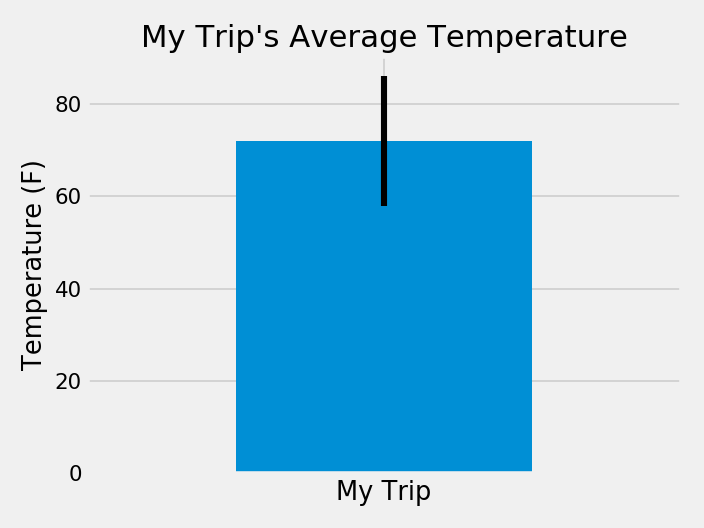

In [122]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(3)

#calculate peak-to-peak (tmax-tmin) value 
p2p = trip_temp_df.max_temperature - trip_temp_df.min_temperature

#plot bar chart with error bar (yerr)
trip_temp_df.average_temperature.plot(kind='bar',yerr=p2p)

#remove xtick
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

#set label and title
plt.xlabel("My Trip")
plt.ylabel("Temperature (F)")
plt.title("My Trip's Average Temperature")

#show the plot
plt.grid(True)
plt.tight_layout()
plt.show()

In [133]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

def calc_rainfall(start_date, end_date):
    
    date_formats = ["%Y/%m/%d", "%Y.%m.%d"]
    for date_fmt in date_formats:
        try:
            start_date = datetime.strptime(start_date, date_fmt).strftime('%Y-%m-%d')
            end_date = datetime.strptime(end_date, date_fmt).strftime('%Y-%m-%d')
        except ValueError:
            continue
        else:
            break

    return session.query(Measurement.station,Measurement.prcp,Station.name,Station.latitude,Station.longitude,\
                                      Station.elevation).join(Station, Station.station == Measurement.station)\
                                        .filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
                                            order_by(Measurement.prcp.desc()).all()


In [134]:
print(calc_rainfall('2017/02/28', '2017-03-05'))

[('USC00517948', 2.4, 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9), ('USC00513117', 2.2, 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6), ('USC00519281', 2.12, 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9), ('USC00516128', 2.0, 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4), ('USC00519281', 1.88, 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9), ('USC00519523', 1.48, 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5), ('USC00513117', 1.45, 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6), ('USC00519397', 1.19, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0), ('USC00514830', 1.12, 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0), ('USC00519397', 0.73, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0), ('USC00519523', 0.59, 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5), ('USC00516128', 0.58, 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4), ('USC00516128', 0.58, 'MANOA LYON ARBO 785.2